In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

from src import tcn
from src.Dataset import CustomDataset
from src.TrainHelpers import plot_loss_graph

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps") 
else:
    device = torch.device("cpu")
print(device)

cuda


In [2]:
### PARAMETERS ###
dataset_ver = '3w05s_Larm'
n_input = 9
n_hidden = 360
seed = 369

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

x_train = np.load(f'input/train_data_{dataset_ver}.npy')
x_val = np.load(f'input/val_data_{dataset_ver}.npy')
x_test = np.load(f'input/test_data_{dataset_ver}.npy')

y_train = np.load(f'input/train_labels_{dataset_ver}.npy')
y_val = np.load(f'input/val_labels_{dataset_ver}.npy')
y_test = np.load(f'input/test_labels_{dataset_ver}.npy')

In [3]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)

(11578, 60, 9)
(11578,)
(1654, 60, 9)


(11578, 60, 9) (3308, 60, 9) (1654, 60, 9)


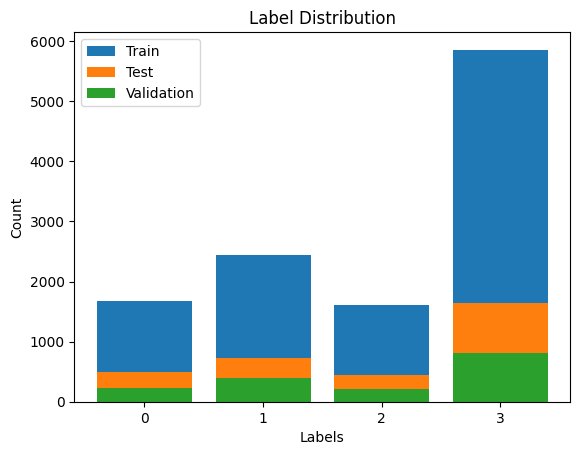

In [4]:
# Check Dataset
print(x_train.shape, x_test.shape, x_val.shape)
unique_labels_train, label_counts_train = np.unique(y_train, return_counts=True)
unique_labels_val, label_counts_val = np.unique(y_val, return_counts=True)
unique_labels_test, label_counts_test = np.unique(y_test, return_counts=True)

plt.bar(unique_labels_train, label_counts_train, label='Train')
plt.bar(unique_labels_test, label_counts_test, label='Test')
plt.bar(unique_labels_val, label_counts_val, label='Validation')

# Set the x-axis tick labels
plt.xticks(unique_labels_train, unique_labels_train)

plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.legend()
plt.show()

In [5]:
### Declare Dataloaders
train_dataset = CustomDataset("train", dataset_ver)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataset = CustomDataset("val", dataset_ver)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)
test_dataset = CustomDataset("test", dataset_ver)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [6]:
for X, y in train_dataloader:
    print(f'{X.shape=}')
    print(f'{y.shape=}')
    break   

X.shape=torch.Size([1, 60, 9])
y.shape=torch.Size([1])


In [7]:
class tcn_classifier(nn.Module):
    def __init__(self, num_inputs, tcn_channels, causal, skip):
        super(tcn_classifier, self).__init__()

        self.tcn = tcn.TCN(num_inputs=num_inputs,
                            num_channels=tcn_channels,
                            causal=causal,
                            input_shape='NLC',
                            use_skip_connections=skip)

    def forward(self, x):
        x = self.tcn(x)
        return x[0][-1]

In [8]:
def train_TCN(model, learning_rate, num_epochs, patience, tag):
    optimizer = optim.Adam(model.parameters(),
                            lr=learning_rate,
                            betas=(0.9, 0.999),
                            eps=1e-8)

    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []

    best_val_loss = np.inf
    es_count = 0

    for epoch in range(num_epochs):
        if es_count < patience:
            print(f'Starting Epoch {epoch+1}...')
            model.train()

            train_preds = []
            train_labels = []

            train_loss = 0
            for train_X, train_y in tqdm(train_dataloader):
                optimizer.zero_grad()
                
                train_output = model(train_X)
                
                train_criterion = criterion(train_output, train_y[0].type(torch.LongTensor))
                train_criterion.backward()
                train_loss += train_criterion.item()
                optimizer.step()

                train_preds.append(torch.argmax(train_output))
                train_labels.append(train_y)

            model.eval()

            val_preds = []
            val_labels = []

            val_loss = 0
            for val_X, val_y in tqdm(val_dataloader):
                val_output = model(val_X)

                val_criterion = criterion(val_output, val_y[0].type(torch.LongTensor))
                val_loss += val_criterion.item()

                val_preds.append(torch.argmax(val_output))
                val_labels.append(val_y)

            train_losses.append(train_loss / len(train_dataloader))
            print(f'Train Loss = {train_losses[-1]}')

            train_acc = accuracy_score(train_labels, train_preds)
            print(f'Train Acc = {train_acc}')

            val_losses.append(val_loss / len(val_dataloader))
            print(f'Val Loss = {val_losses[-1]}')

            val_acc = accuracy_score(val_labels, val_preds)
            print(f'Val Acc = {val_acc}')

            if val_losses[-1] < best_val_loss:
                torch.save(deepcopy(model.state_dict()), f'ML_Models/TCN_{tag}.pt')
                best_val_loss = val_losses[-1]
                es_count = 0
                continue
            
            es_count += 1

        else:
            print('Early Stopping...')
            break

    return train_losses, val_losses


tcn_classifier(
  (tcn): TCN(
    (network): ModuleList(
      (0): TemporalBlock(
        (conv1): ParametrizedCausalConv1d(
          9, 128, kernel_size=(4,), stride=(1,)
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
        (conv2): ParametrizedCausalConv1d(
          128, 128, kernel_size=(4,), stride=(1,)
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
        (activation1): ReLU()
        (activation2): ReLU()
        (activation_final): ReLU()
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
        (downsample): Conv1d(9, 128, kernel_size=(1,), stride=(1,))
      )
      (1): TemporalBlock(
        (conv1): ParametrizedCausalConv1d(
          128, 64, kernel_size=(4,), stride=(1,), dilation=(2,)
          (parametriz

  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.5969278276471544
Train Acc = 0.7667127310416306
Val Loss = 0.38784750749610514
Val Acc = 0.8355501813784765
Starting Epoch 2...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.3683426802526734
Train Acc = 0.8577474520642598
Val Loss = 0.33676811944067137
Val Acc = 0.8688029020556227
Starting Epoch 3...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.2925352876989331
Train Acc = 0.8903092071169459
Val Loss = 0.2525618910396609
Val Acc = 0.9099153567110037
Starting Epoch 4...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.24313623140835275
Train Acc = 0.9103472102262913
Val Loss = 0.2023991906130725
Val Acc = 0.9214026602176542
Starting Epoch 5...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.22621255333362839
Train Acc = 0.9172568664708931
Val Loss = 0.16537492207790114
Val Acc = 0.9401451027811366
Starting Epoch 6...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.20315844949597892
Train Acc = 0.9271894973225082
Val Loss = 0.19441057726784985
Val Acc = 0.9274486094316807
Starting Epoch 7...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.18643975154438694
Train Acc = 0.9336673000518224
Val Loss = 0.12883207996457846
Val Acc = 0.9534461910519951
Starting Epoch 8...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.17325246292407384
Train Acc = 0.9403178441872517
Val Loss = 0.20776856125397453
Val Acc = 0.9195888754534461
Starting Epoch 9...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.15656773697326254
Train Acc = 0.9458455691829332
Val Loss = 0.1275063507523237
Val Acc = 0.9498186215235792
Starting Epoch 10...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.1449891672060317
Train Acc = 0.9492140266021766
Val Loss = 0.12694554405841574
Val Acc = 0.9510278113663845
Starting Epoch 11...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.13880849831915165
Train Acc = 0.9528415961305925
Val Loss = 0.13057734764769074
Val Acc = 0.9504232164449818
Starting Epoch 12...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.12024209971523385
Train Acc = 0.9584556918293314
Val Loss = 0.11823503627221119
Val Acc = 0.9588875453446191
Starting Epoch 13...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.12577223644300958
Train Acc = 0.9561236828467784
Val Loss = 0.19213138979656283
Val Acc = 0.9540507859733979
Starting Epoch 14...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.11742906254975603
Train Acc = 0.9596648816721368
Val Loss = 0.1090219113348822
Val Acc = 0.9625151148730351
Starting Epoch 15...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.10906323020368695
Train Acc = 0.9615650371394023
Val Loss = 0.08021097966835347
Val Acc = 0.9691656590084643


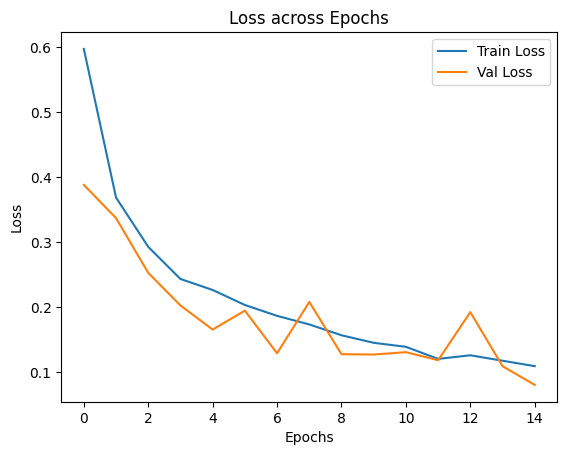

In [9]:
tcn_model_1 = tcn_classifier(9, [128, 64, 32, 16, 4], True, False)
tag = f'TCN_{dataset_ver}_Causal_128-64-32-16-4'
print(tcn_model_1)
train_losses, val_losses = train_TCN(tcn_model_1, 1e-3, 15, 5, tag)
plot_loss_graph(train_losses, val_losses, tag)

tcn_classifier(
  (tcn): TCN(
    (network): ModuleList(
      (0): TemporalBlock(
        (conv1): ParametrizedTemporalConv1d(
          9, 128, kernel_size=(4,), stride=(1,), padding=(1,)
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
        (conv2): ParametrizedTemporalConv1d(
          128, 128, kernel_size=(4,), stride=(1,), padding=(1,)
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
        (activation1): ReLU()
        (activation2): ReLU()
        (activation_final): ReLU()
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
        (downsample): Conv1d(9, 128, kernel_size=(1,), stride=(1,))
      )
      (1): TemporalBlock(
        (conv1): ParametrizedTemporalConv1d(
          128, 64, kernel_size=(4,), stride=(1,), p

  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.779802862308728
Train Acc = 0.6977889100017274
Val Loss = 0.7109175649197577
Val Acc = 0.7351874244256348
Starting Epoch 2...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.5664924008986739
Train Acc = 0.8239765071687684
Val Loss = 0.4708901116699259
Val Acc = 0.8288996372430472
Starting Epoch 3...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.4960832529395042
Train Acc = 0.8606840559682156
Val Loss = 0.4272526553527935
Val Acc = 0.8996372430471584
Starting Epoch 4...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.4599711172892388
Train Acc = 0.8853860770426671
Val Loss = 0.4649887201141085
Val Acc = 0.8669891172914147
Starting Epoch 5...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.4388256806217406
Train Acc = 0.8926412160994991
Val Loss = 0.4000097422727707
Val Acc = 0.905683192261185
Starting Epoch 6...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.4194288621553033
Train Acc = 0.9030920711694593
Val Loss = 0.37073317973964826
Val Acc = 0.914752116082225
Starting Epoch 7...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.40006536051150726
Train Acc = 0.913111072724132
Val Loss = 0.36652311390121517
Val Acc = 0.9256348246674728
Starting Epoch 8...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.38614797905907267
Train Acc = 0.920884435999309
Val Loss = 0.3647137981733578
Val Acc = 0.9304715840386941
Starting Epoch 9...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.37851326733016394
Train Acc = 0.9258939367766453
Val Loss = 0.3297971508857259
Val Acc = 0.9389359129383313
Starting Epoch 10...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.37297656807661694
Train Acc = 0.9282259457591985
Val Loss = 0.32049627407764314
Val Acc = 0.9455864570737605
Starting Epoch 11...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.35124717036852815
Train Acc = 0.9379858352046986
Val Loss = 0.33207920562624826
Val Acc = 0.9407496977025392
Starting Epoch 12...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.34477250724983893
Train Acc = 0.939367766453619
Val Loss = 0.3437571645718185
Val Acc = 0.9316807738814994
Starting Epoch 13...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.33958520539532533
Train Acc = 0.9437726723095526
Val Loss = 0.38055020661652444
Val Acc = 0.9274486094316807
Starting Epoch 14...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.3347416604034308
Train Acc = 0.9434271894973225
Val Loss = 0.33013287634609517
Val Acc = 0.9401451027811366
Starting Epoch 15...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.3278269871736394
Train Acc = 0.9485230609777163
Val Loss = 0.30057286659472765
Val Acc = 0.9546553808948005


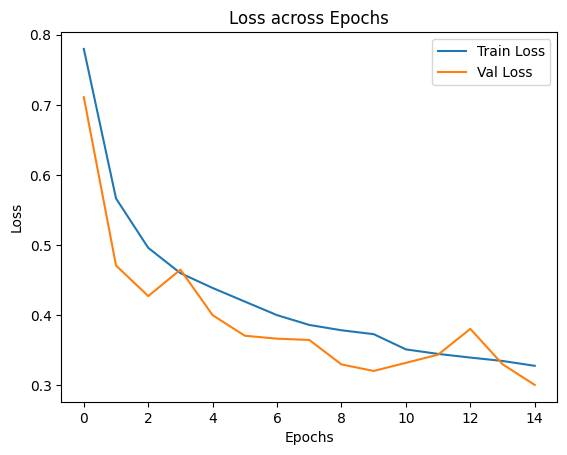

In [10]:
tcn_model_2 = tcn_classifier(9, [128, 64, 32, 16, 4], False, False)
tag = f'TCN_{dataset_ver}_NonCausal_128-64-32-16-4'
print(tcn_model_2)
train_losses, val_losses = train_TCN(tcn_model_2, 1e-3, 15, 5, tag)
plot_loss_graph(train_losses, val_losses, tag)

tcn_classifier(
  (tcn): TCN(
    (downsample_skip_connection): ModuleList(
      (0): Conv1d(128, 4, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 4, kernel_size=(1,), stride=(1,))
      (2): Conv1d(32, 4, kernel_size=(1,), stride=(1,))
      (3): Conv1d(16, 4, kernel_size=(1,), stride=(1,))
      (4): None
    )
    (activation_skip_out): ReLU()
    (network): ModuleList(
      (0): TemporalBlock(
        (conv1): ParametrizedCausalConv1d(
          9, 128, kernel_size=(4,), stride=(1,)
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
        (conv2): ParametrizedCausalConv1d(
          128, 128, kernel_size=(4,), stride=(1,)
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
        (activation1): ReLU()
        (activation2): ReLU()
        (activation_final): ReLU()
   

  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.7714250736371169
Train Acc = 0.7001209189842805
Val Loss = 0.5511447048780703
Val Acc = 0.7859733978234583
Starting Epoch 2...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.5192702181201357
Train Acc = 0.7969424771117637
Val Loss = 0.4653830246248277
Val Acc = 0.8089480048367593
Starting Epoch 3...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.45668613651766166
Train Acc = 0.8103299360856797
Val Loss = 0.41142268262829584
Val Acc = 0.8270858524788391
Starting Epoch 4...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.41066279744197476
Train Acc = 0.8195716013128347
Val Loss = 0.3458436415521306
Val Acc = 0.8355501813784765
Starting Epoch 5...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.385012547693099
Train Acc = 0.8220763517015028
Val Loss = 0.35331269347405847
Val Acc = 0.837968561064087
Starting Epoch 6...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.3688989067693775
Train Acc = 0.8238901364657109
Val Loss = 0.32065461039312254
Val Acc = 0.8422007255139057
Starting Epoch 7...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.35592545216087046
Train Acc = 0.8295042321644498
Val Loss = 0.3567505549315045
Val Acc = 0.8391777509068924
Starting Epoch 8...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.34454292669730674
Train Acc = 0.8293314907583348
Val Loss = 0.33371951260485994
Val Acc = 0.8385731559854898
Starting Epoch 9...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.32780944032730086
Train Acc = 0.8319226118500604
Val Loss = 0.3098244687497648
Val Acc = 0.8464328899637243
Starting Epoch 10...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.3262107403725317
Train Acc = 0.8327863188806357
Val Loss = 0.3097852194387674
Val Acc = 0.8409915356711004
Starting Epoch 11...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.31453702305230846
Train Acc = 0.8345137329417861
Val Loss = 0.3122770188911896
Val Acc = 0.8385731559854898
Starting Epoch 12...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.30365360665997315
Train Acc = 0.8388322680946623
Val Loss = 0.29416071292309626
Val Acc = 0.8482466747279322
Starting Epoch 13...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.3057324912608531
Train Acc = 0.8362411470029366
Val Loss = 0.28141038338024454
Val Acc = 0.8512696493349455
Starting Epoch 14...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.30008441136762176
Train Acc = 0.8374503368457419
Val Loss = 0.29967486038325447
Val Acc = 0.8391777509068924
Starting Epoch 15...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.2944348145767497
Train Acc = 0.8400414579374677
Val Loss = 0.34568101339861423
Val Acc = 0.837968561064087


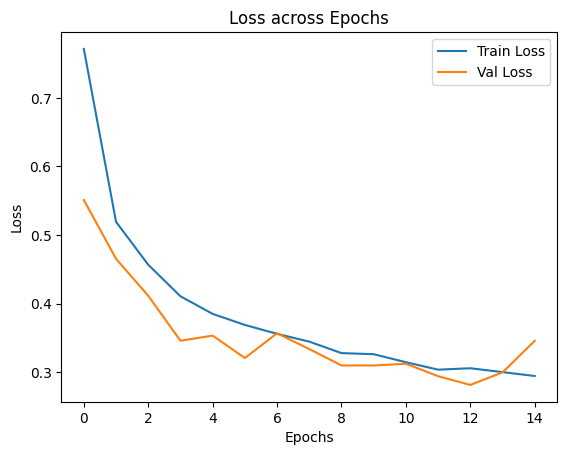

In [9]:
tcn_model_3 = tcn_classifier(9, [128, 64, 32, 16, 4], True, True)
tag = f'TCN_{dataset_ver}_CausalSkip_128-64-32-16-4'
print(tcn_model_3)
train_losses, val_losses = train_TCN(tcn_model_3, 1e-3, 15, 5, tag)
plot_loss_graph(train_losses, val_losses, tag)

tcn_classifier(
  (tcn): TCN(
    (downsample_skip_connection): ModuleList(
      (0): Conv1d(128, 4, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 4, kernel_size=(1,), stride=(1,))
      (2): Conv1d(32, 4, kernel_size=(1,), stride=(1,))
      (3): Conv1d(16, 4, kernel_size=(1,), stride=(1,))
      (4): None
    )
    (activation_skip_out): ReLU()
    (network): ModuleList(
      (0): TemporalBlock(
        (conv1): ParametrizedTemporalConv1d(
          9, 128, kernel_size=(4,), stride=(1,), padding=(1,)
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
        (conv2): ParametrizedTemporalConv1d(
          128, 128, kernel_size=(4,), stride=(1,), padding=(1,)
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
        (activation1): ReLU()
        (activation2): ReLU()
      

  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.7680669045596125
Train Acc = 0.7015892209362584
Val Loss = 0.6508722526433471
Val Acc = 0.7938331318016929
Starting Epoch 2...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.49285850196418407
Train Acc = 0.8242356192779409
Val Loss = 0.3761048316501075
Val Acc = 0.8476420798065296
Starting Epoch 3...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.35069486260482957
Train Acc = 0.8672482294005873
Val Loss = 0.3239050246525123
Val Acc = 0.8681983071342201
Starting Epoch 4...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.29944975038267835
Train Acc = 0.8878044567282778
Val Loss = 0.29289241267883653
Val Acc = 0.9032648125755743
Starting Epoch 5...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.26649454870125466
Train Acc = 0.900241837968561
Val Loss = 0.2574737080295257
Val Acc = 0.9044740024183797
Starting Epoch 6...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.23536725656452875
Train Acc = 0.9144066332699948
Val Loss = 0.2031997374564411
Val Acc = 0.9268440145102781
Starting Epoch 7...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.21036487684419794
Train Acc = 0.9227845914665745
Val Loss = 0.1668148270434465
Val Acc = 0.9353083434099153
Starting Epoch 8...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.20239696961987502
Train Acc = 0.9284850578683711
Val Loss = 0.19617216175601523
Val Acc = 0.9274486094316807
Starting Epoch 9...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.18490989952952644
Train Acc = 0.9350492313007428
Val Loss = 0.16009630188183224
Val Acc = 0.9419588875453446
Starting Epoch 10...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.1700640064475619
Train Acc = 0.9410951805147694
Val Loss = 0.16909748440291492
Val Acc = 0.9359129383313181
Starting Epoch 11...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.16441445703653235
Train Acc = 0.9420452582484021
Val Loss = 0.19694768505348392
Val Acc = 0.9153567110036276
Starting Epoch 12...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.15358575265945817
Train Acc = 0.9476593539471412
Val Loss = 0.14400776409875507
Val Acc = 0.9455864570737605
Starting Epoch 13...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.13987971180008993
Train Acc = 0.9495595094144066
Val Loss = 0.1653980764445757
Val Acc = 0.9437726723095526
Starting Epoch 14...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.12992333864261488
Train Acc = 0.9559509414406633
Val Loss = 0.13485489641374862
Val Acc = 0.9540507859733979
Starting Epoch 15...


  0%|          | 0/11578 [00:00<?, ?it/s]

  0%|          | 0/1654 [00:00<?, ?it/s]

Train Loss = 0.12704150817958906
Train Acc = 0.9561236828467784
Val Loss = 0.21561516389576776
Val Acc = 0.9371221281741233


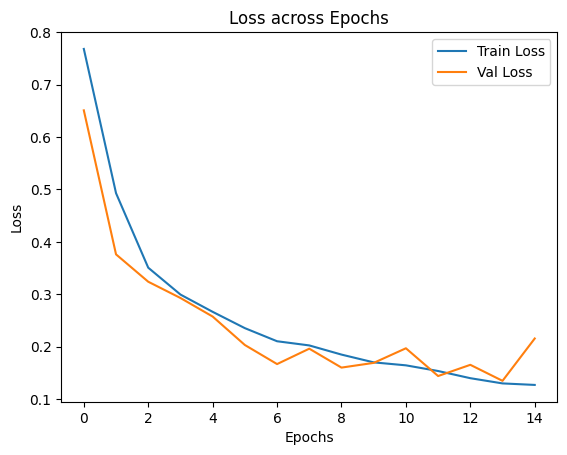

In [9]:
tcn_model_4 = tcn_classifier(9, [128, 64, 32, 16, 4], False, True)
tag = f'TCN_{dataset_ver}_NonCausalSkip_128-64-32-16-4'
print(tcn_model_4)
train_losses, val_losses = train_TCN(tcn_model_4, 1e-3, 15, 5, tag)
plot_loss_graph(train_losses, val_losses, tag)